In [35]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

filepath = 'data/NSL-KDD/KDDTrain+.arff'

In [36]:
def loadDataset(filepath):
    """
    Loads a dataset from an ARFF file and converts it into a pandas DataFrame.

    Args:
        filepath (str): The path to the ARFF file to be loaded.

    Returns:
        pd.DataFrame: A DataFrame containing the data from the ARFF file, with columns named according to the attributes in the ARFF file.
    """
    with open(filepath, 'r') as f:
        dataset = arff.load(f)
        df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])
    return df

df = loadDataset(filepath)

In [37]:
def splitDataset(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)

    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    
    return (train_set, val_set, test_set)

# def splitDataset(df, test_size=0.2, val_size=0.1, random_state=42):
#     train_val_set, test_set = train_test_split(df, test_size=test_size, random_state=random_state)
#     train_set, val_set = train_test_split(train_val_set, test_size=val_size, random_state=random_state)
#
#     return train_set, val_set, test_set

train_set, val_set, test_set = splitDataset(df)

In [38]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), ('rbst_scaler', RobustScaler()), ])

# for upgrade f1-score
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [39]:
class CustomOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._columns = None

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, columns=self._columns, index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)
    
# categorical_features = df.select_dtypes(include=['object']).columns.tolist()
# categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

In [40]:
class DataFramePreparer(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
        
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        
        # self._full_pipeline = ColumnTransformer([("num", numeric_transformer, num_attribs), ("cat", categorical_transformer, cat_attribs), ])
        self._full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", CustomOneHotEncoding(), cat_attribs),])
        
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, columns=self._columns, index=X_copy.index)

In [41]:
# df = loadDataset(filepath)

In [42]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [43]:
# train_set, val_set, test_set = splitDataset(df)

In [44]:
print("Len - Training Set:", len(train_set))
print("Len - Validation Set:", len(val_set))
print("Len - Test Set:", len(test_set))

Len - Training Set: 75583
Len - Validation Set: 25195
Len - Test Set: 25195


In [45]:
X = df.drop('class', axis=1)
y = df['class']

In [46]:
X_train = train_set.drop('class', axis=1)
y_train = train_set['class']

In [47]:
X_val = val_set.drop('class', axis=1)
y_val = val_set['class']

In [48]:
X_test = test_set.drop('class', axis=1)
y_test = test_set['class']

In [49]:
data_preparer = DataFramePreparer()

In [50]:
data_preparer.fit(X)

DataFramePreparer()

In [51]:
X_train_prep = data_preparer.transform(X_train)

In [52]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0


In [53]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
98320,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8590,0.0,6.224638,0.641473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
91385,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
54349,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
69568,0.0,5.340580,0.662791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [54]:
X_val_prep = data_preparer.transform(X_val)

In [55]:
clf = LogisticRegression(solver='newton-cg', max_iter=1000) # F1 score: 0.9681479578731056
clf.fit(X_train_prep, y_train)

"""
    Note: f1-score rancking
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000) # F1 score: 0.980279578731056
    clf = LogisticRegression(solver='newton-cg', max_iter=10000) # F1 score: 0.9681479578731056
    clf = LogisticRegression(solver='lbfgs', max_iter=10000) # F1 score: 0.9677253659789402
    clf = LogisticRegression(solver='liblinear', max_iter=10000) # F1 score: 0.9666023579849946
    clf = LogisticRegression(solver='sag', max_iter=10000) # F1 score: 0.8502648401826484
    clf = LogisticRegression(solver='saga', max_iter=10000) # F1 score: 0.7137047827142511
"""

def optimizeLogisticRegression(X_train_prep, y_train):
    param_grid = {
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [1000, 5000, 10000]
    }

    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_prep, y_train)

    clf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return clf, best_params, best_score

# clf, best_params, best_score = optimizeLogisticRegression(X_train_prep, y_train)
# print("Best parameters found: ", best_params)
# print("Best F1-Score: ", best_score)

## Predicción de nuevos ejemplos

Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Utilizamos el subconjunto de validación.

In [56]:
y_pred = clf.predict(X_val_prep)

## 1. Matriz de Confusión

In [57]:
confusion_matrix(y_val, y_pred)

array([[11459,   415],
       [  256, 13065]])

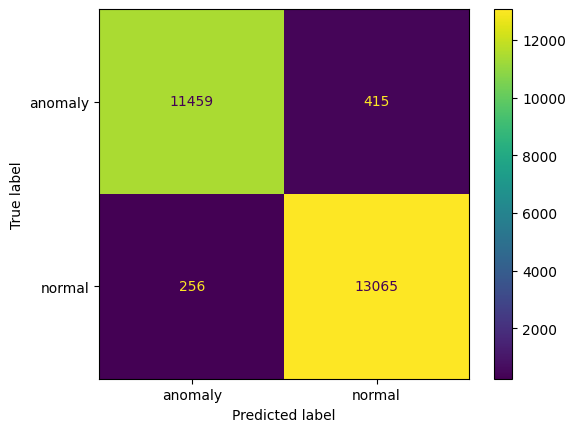

In [58]:
ConfusionMatrixDisplay.from_estimator(clf, X_val_prep, y_val, values_format='d')

### Precisión

In [59]:
print("Precision:", precision_score(y_val, y_pred, pos_label='anomaly'))

Precision: 0.9781476739223218


### Recall

In [60]:
print("Recall:", recall_score(y_val, y_pred, pos_label='anomaly'))

Recall: 0.9650496883948122


### F1 Score

In [61]:
print("F1-score:", f1_score(y_val, y_pred, pos_label='anomaly'))

F1-score: 0.9715545381321803


### ROC's curve

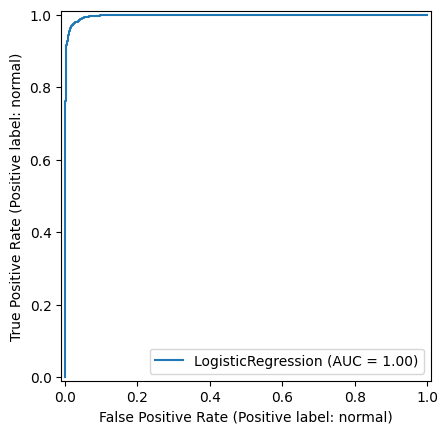

In [62]:
RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

### PR's curve

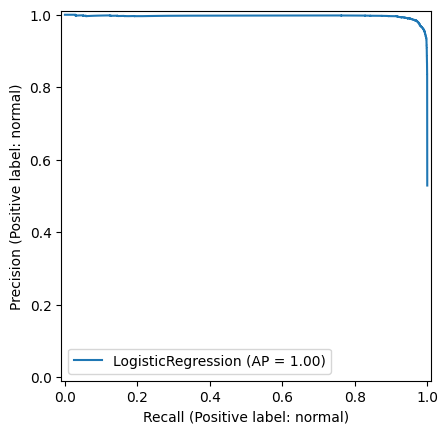

In [63]:
PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val)

In [64]:
X_test_prep = data_preparer.transform(X_test)

In [65]:
y_pred = clf.predict(X_test_prep)

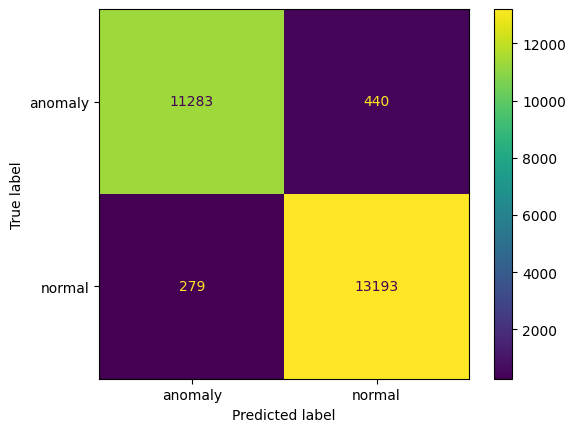

In [66]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_prep, y_test, values_format='d')

In [67]:
print("F1-score:", f1_score(y_test, y_pred, pos_label='anomaly'))

F1-score: 0.9691217522009877


In [68]:
def optimizeModel(train_set, val_set):
    X_train = train_set.drop('class', axis=1)
    y_train = train_set['class']
    X_val = val_set.drop('class', axis=1)
    y_val = val_set['class']

    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    
    modelPipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])
    paramGrid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }

    grid_search = GridSearchCV(modelPipeline, paramGrid, cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    bestModel = grid_search.best_estimator_
    f1Val = grid_search.score(X_val, y_val)
    
    return bestModel, f1Val

bestModel, f1Val = optimizeModel(train_set, val_set)

print("Best model found:", bestModel)
print("F1-Score:", f1Val)

Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                     